## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# DEPENDENCIES INSTALLATION
# ============================================================================

!pip install jax jaxlib optax flax pandas numpy matplotlib seaborn scikit-learn optuna -q

print("✓ All dependencies installed")

✓ All dependencies installed


In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import time
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# JAX ecosystem
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from flax import linen as nn
from flax.training import train_state

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score,
    classification_report,
    accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# Check JAX device
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")
print(f"Default backend: {jax.default_backend()}")


JAX version: 0.5.2
Available devices: [CudaDevice(id=0), CudaDevice(id=1)]
Default backend: gpu


In [3]:
# ============================================================================
# CONFIGURATION - TRULY RANDOM SEED
# ============================================================================

RANDOM_SEED = int(time.time() * 1000) % (2**31)
np.random.seed(RANDOM_SEED)

print(f"\n✓ Using TRULY RANDOM seed: {RANDOM_SEED}")
print(f"  (Seed generated from current time, not fixed)")

PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']
NUM_CLASSES = len(PARTICLE_NAMES)

# ============================================================================
# CONFIGURATION - 3 MOMENTUM RANGES + MODEL TYPES (NO OPTUNA)
# ============================================================================

MODEL_TYPES = ['JAX_SimpleNN', 'JAX_DNN']

# 3 momentum ranges
MOMENTUM_RANGES = [
    {'min': 0.1, 'max': 999, 'name': 'Full Spectrum (0.1-∞ GeV/c)', 'key': 'full'},
    {'min': 0.7, 'max': 1.5, 'name': '0.7-1.5 GeV/c (Critical)', 'key': '0.7-1.5'},
    {'min': 1.0, 'max': 3.0, 'name': '1-3 GeV/c (Intermediate)', 'key': '1-3'}
]

# ============================================================================
# DIRECTORIES
# ============================================================================

BASE_DIR = '/kaggle/working'
SAVE_DIR = os.path.join(BASE_DIR, 'trained_models')
INPUT_DIR = '/kaggle/input/jax-models'

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n✓ Configuration loaded")
print(f"  Model types: {MODEL_TYPES}")
print(f"  NO Optuna - using fixed hyperparameters")
print(f"  Momentum ranges: {len(MOMENTUM_RANGES)}")
print(f"  Total models to train: {len(MODEL_TYPES) * len(MOMENTUM_RANGES)} = 6 models")
print(f"  Save directory: {SAVE_DIR}")
print(f"  Input directory: {INPUT_DIR}")

all_results_by_model_and_range = {}

# ============================================================================
# HELPER FUNCTIONS FOR SAVING/LOADING INDIVIDUAL MODELS
# ============================================================================

def get_model_filename(momentum_key, model_type):
    """Generate filename for individual model (no Optuna mode)"""
    return f"{momentum_key}_{model_type}.pkl"

def save_single_model(momentum_key, model_type, results):
    """Save a single model's results"""
    filename = get_model_filename(momentum_key, model_type)
    filepath = os.path.join(SAVE_DIR, filename)
    
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(results, f)
        file_size_kb = os.path.getsize(filepath) / 1024
        print(f"  ✓ Saved: {filename} ({file_size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"  ✗ Error saving {filename}: {e}")
        return False

def load_single_model(momentum_key, model_type, source='working'):
    """Load a single model's results"""
    filename = get_model_filename(momentum_key, model_type)
    
    if source == 'working':
        filepath = os.path.join(SAVE_DIR, filename)
    else:
        filepath = os.path.join(INPUT_DIR, filename)
    
    if os.path.exists(filepath):
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            return results, filepath
        except Exception as e:
            print(f"  ✗ Error loading {filename}: {e}")
            return None, None
    
    return None, None

print("\n✓ Section 1 COMPLETE")



✓ Using TRULY RANDOM seed: 471643728
  (Seed generated from current time, not fixed)

✓ Configuration loaded
  Model types: ['JAX_SimpleNN', 'JAX_DNN']
  NO Optuna - using fixed hyperparameters
  Momentum ranges: 3
  Total models to train: 6 = 6 models
  Save directory: /kaggle/working/trained_models
  Input directory: /kaggle/input/jax-models

✓ Section 1 COMPLETE


## Section 2: Data Loading & Preprocessing

In [4]:
# ============================================================================
# SECTION 2: DATA LOADING & PREPROCESSING WITH IMPROVED MISSING VALUE HANDLING
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 2: DATA LOADING & PREPROCESSING")
print(f"{'#'*80}")

# ============================================================================
# LOAD DATA
# ============================================================================

CSV_PATH = '/kaggle/input/pid-features/pid_features_large.csv'

print("\nLoading data (shared for all model analyses)...")
df_iter = pd.read_csv(CSV_PATH, dtype='float32', chunksize=500000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)

print(f"✓ Loaded: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

# ============================================================================
# PREPROCESSING FUNCTION WITH IMPROVED MISSING VALUE HANDLING
# ============================================================================

def preprocess_momentum_range(df, momentum_range):
    """
    Enhanced preprocessing with physics-informed missing value handling
    """
    print(f"\n{'─'*80}")
    print(f"Preprocessing: {momentum_range['name']}")
    print(f"{'─'*80}")
    
    # Filter by momentum range
    df_filtered = df[(df['p'] >= momentum_range['min']) & 
                     (df['p'] < momentum_range['max'])].copy()
    
    print(f"  Samples after momentum filter: {len(df_filtered):,}")
    
    # Define training features
    training_features = [
        'pt', 'eta', 'phi',
        'tpc_signal', 
        'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
        'tof_beta',
        'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
        'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
        'dca_xy', 'dca_z',
        'has_tpc', 'has_tof'
    ]
    
    # ========================================================================
    # IMPROVED MISSING VALUE HANDLING
    # ========================================================================
    
    print("\n  Missing value analysis:")
    missing_before = df_filtered[training_features].isnull().sum()
    total_missing = missing_before.sum()
    
    if total_missing > 0:
        print(f"    Total missing values before handling: {total_missing:,}")
        for feat in training_features:
            missing_count = missing_before[feat]
            if missing_count > 0:
                missing_pct = (missing_count / len(df_filtered)) * 100
                print(f"      {feat:25s}: {missing_count:6,} ({missing_pct:.2f}%)")
    else:
        print(f"    No missing values detected")
    
    # Strategy 1: Fill TOF variables with detector-aware defaults
    # When TOF is not available, use physics-motivated defaults
    tof_features = ['tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 
                    'tof_nsigma_pr', 'tof_nsigma_el']
    
    for feat in tof_features:
        if feat in df_filtered.columns:
            if feat == 'tof_beta':
                # Beta = 0 indicates no TOF measurement
                df_filtered[feat].fillna(0.0, inplace=True)
            else:
                # nsigma = 999 indicates "no TOF information"
                df_filtered[feat].fillna(999.0, inplace=True)
    
    # Strategy 2: Fill TPC variables with detector-aware defaults
    tpc_features = ['tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka',
                    'tpc_nsigma_pr', 'tpc_nsigma_el']
    
    for feat in tpc_features:
        if feat in df_filtered.columns:
            if feat == 'tpc_signal':
                # Use 0 for missing TPC signal
                df_filtered[feat].fillna(0.0, inplace=True)
            else:
                # nsigma = 999 for no TPC information
                df_filtered[feat].fillna(999.0, inplace=True)
    
    # Strategy 3: Fill Bayesian probabilities with uniform distribution
    # When missing, assume equal probability for all particle types
    bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 
                      'bayes_prob_pr', 'bayes_prob_el']
    
    for feat in bayes_features:
        if feat in df_filtered.columns:
            df_filtered[feat].fillna(0.25, inplace=True)  # Uniform probability
    
    # Strategy 4: Fill kinematic and DCA features with median
    kinematic_features = ['pt', 'eta', 'phi', 'dca_xy', 'dca_z']
    for feat in kinematic_features:
        if feat in df_filtered.columns:
            median_val = df_filtered[feat].median()
            df_filtered[feat].fillna(median_val, inplace=True)
    
    # Strategy 5: Fill detector flags with 0 (not available)
    df_filtered['has_tpc'].fillna(0, inplace=True)
    df_filtered['has_tof'].fillna(0, inplace=True)
    
    # Verify no missing values remain
    missing_after = df_filtered[training_features].isnull().sum().sum()
    print(f"\n    Total missing values after handling: {missing_after}")
    
    if missing_after > 0:
        print("    ⚠ Warning: Some missing values remain, dropping rows...")
        df_filtered.dropna(subset=training_features, inplace=True)
        print(f"    Samples after dropping missing: {len(df_filtered):,}")
    
    # ========================================================================
    # CONTINUE WITH NORMAL PREPROCESSING
    # ========================================================================
    
    X = df_filtered[training_features].values
    y = df_filtered['mc_pdg'].values
    
    # Map PDG codes to species
    def pdg_to_species(pdg):
        ap = abs(int(pdg))
        if ap == 211:
            return 0  # Pion
        elif ap == 321:
            return 1  # Kaon
        elif ap == 2212:
            return 2  # Proton
        elif ap == 11:
            return 3  # Electron
        else:
            return -1  # Unknown
    
    y = np.array([pdg_to_species(pdg) for pdg in y])
    
    # Remove unknown particles
    valid_mask = y >= 0
    X = X[valid_mask]
    y = y[valid_mask]
    
    print(f"\n  Final dataset shape: {X.shape}")
    print(f"  Class distribution:")
    for i, particle in enumerate(PARTICLE_NAMES):
        count = np.sum(y == i)
        pct = (count / len(y)) * 100
        print(f"    {particle:10s}: {count:6,} ({pct:5.2f}%)")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n  Train samples: {len(X_train):,}")
    print(f"  Test samples:  {len(X_test):,}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, training_features

print(f"\n{'='*80}")
print("✓ SECTION 2 COMPLETE: Data loaded and preprocessing function defined")
print(f"{'='*80}")
print("\nKey improvements:")
print("  ✓ Physics-informed missing value handling")
print("  ✓ TOF variables: 0 or 999 for missing data")
print("  ✓ TPC variables: 0 or 999 for missing data")
print("  ✓ Bayesian probabilities: uniform distribution (0.25)")
print("  ✓ Kinematics: median imputation")
print("  ✓ Ready for 3 momentum ranges (Full, 0.7-1.5, 1-3 GeV/c)")



################################################################################
SECTION 2: DATA LOADING & PREPROCESSING
################################################################################

Loading data (shared for all model analyses)...
✓ Loaded: (4729393, 37)
  Rows: 4,729,393
  Columns: 37

✓ SECTION 2 COMPLETE: Data loaded and preprocessing function defined

Key improvements:
  ✓ Physics-informed missing value handling
  ✓ TOF variables: 0 or 999 for missing data
  ✓ TPC variables: 0 or 999 for missing data
  ✓ Bayesian probabilities: uniform distribution (0.25)
  ✓ Kinematics: median imputation
  ✓ Ready for 3 momentum ranges (Full, 0.7-1.5, 1-3 GeV/c)


## Section 3: Training Steps with BatchNorm Support

In [11]:
# ============================================================================
# SECTION 3: JAX MODEL ARCHITECTURES & TRAINING UTILITIES
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES")
print(f"{'#'*80}")

# ============================================================================
# JAX MODEL ARCHITECTURES
# ============================================================================

class JAX_SimpleNN(nn.Module):
    """Simple feedforward neural network"""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x

class JAX_DNN(nn.Module):
    """Deeper neural network with batch normalization"""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.BatchNorm(use_running_average=not training)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x

print("✓ Model architectures defined:")
print("  - JAX_SimpleNN: Simple feedforward network")
print("  - JAX_DNN: Deeper network with batch normalization")

# ============================================================================
# TRAINING FUNCTIONS - SIMPLE (NO BATCHNORM)
# ============================================================================

@jit
def train_step_simple(state, batch_x, batch_y, rng, class_weights):
    """Training step for models WITHOUT BatchNorm (JAX_SimpleNN)"""
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params}, batch_x, training=True, rngs={'dropout': rng}
        )
        # Weighted cross-entropy loss
        one_hot = jax.nn.one_hot(batch_y, NUM_CLASSES)
        log_probs = jax.nn.log_softmax(logits, axis=-1)
        weights = class_weights[batch_y]
        loss = -jnp.sum(weights[:, None] * one_hot * log_probs) / batch_y.shape[0]
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def eval_step_simple(state, batch_x, batch_y):
    """Evaluation step for models WITHOUT BatchNorm"""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits

print("✓ Simple training utilities defined (for JAX_SimpleNN)")

# ============================================================================
# TRAINING FUNCTIONS - WITH BATCHNORM
# ============================================================================

@jit
def train_step_batchnorm(state, batch_x, batch_y, rng, class_weights):
    """Training step for models WITH BatchNorm (JAX_DNN)"""
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(
            variables, batch_x, training=True, 
            rngs={'dropout': rng}, mutable=['batch_stats']
        )
        # Weighted cross-entropy loss
        one_hot = jax.nn.one_hot(batch_y, NUM_CLASSES)
        log_probs = jax.nn.log_softmax(logits, axis=-1)
        weights = class_weights[batch_y]
        loss = -jnp.sum(weights[:, None] * one_hot * log_probs) / batch_y.shape[0]
        return loss, new_model_state
    
    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss

@jit
def eval_step_batchnorm(state, batch_x, batch_y):
    """Evaluation step for models WITH BatchNorm"""
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits

print("✓ BatchNorm training utilities defined (for JAX_DNN)")

# ============================================================================
# BATCH EVALUATION UTILITIES
# ============================================================================

def batch_evaluate_simple(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for models WITHOUT BatchNorm"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_simple(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits

def batch_evaluate_batchnorm(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for models WITH BatchNorm"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_batchnorm(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits

print("✓ Batch evaluation utilities defined (separate for Simple/BatchNorm models)")

# ============================================================================
# EXTENDED TRAINSTATE FOR BATCHNORM
# ============================================================================

class TrainStateWithBatchStats(train_state.TrainState):
    """Extended TrainState that includes batch_stats for BatchNorm"""
    batch_stats: any = None

print("✓ Extended TrainState defined for BatchNorm models")

# ============================================================================
# FIXED HYPERPARAMETERS (NO OPTUNA)
# ============================================================================

HYPERPARAMETERS = {
    'JAX_SimpleNN': {
        'hidden_dims': [512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 10
    },
    'JAX_DNN': {
        'hidden_dims': [1024, 512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.00005,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 10
    }
}

print("\n✓ Fixed Hyperparameters (No Optuna):")
for model_type, params in HYPERPARAMETERS.items():
    print(f"\n  {model_type}:")
    print(f"    Hidden dims:    {params['hidden_dims']}")
    print(f"    Dropout rate:   {params['dropout_rate']}")
    print(f"    Learning rate:  {params['learning_rate']}")
    print(f"    Batch size:     {params['batch_size']}")
    print(f"    Num epochs:     {params['num_epochs']}")
    print(f"    Patience:       {params['patience']}")

print(f"\n{'='*80}")
print("✓ SECTION 3 COMPLETE: Models and training utilities ready")
print(f"{'='*80}")



################################################################################
SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES
################################################################################
✓ Model architectures defined:
  - JAX_SimpleNN: Simple feedforward network
  - JAX_DNN: Deeper network with batch normalization
✓ Simple training utilities defined (for JAX_SimpleNN)
✓ BatchNorm training utilities defined (for JAX_DNN)
✓ Batch evaluation utilities defined (separate for Simple/BatchNorm models)
✓ Extended TrainState defined for BatchNorm models

✓ Fixed Hyperparameters (No Optuna):

  JAX_SimpleNN:
    Hidden dims:    [512, 256, 128, 64]
    Dropout rate:   0.5
    Learning rate:  0.0001
    Batch size:     256
    Num epochs:     100
    Patience:       10

  JAX_DNN:
    Hidden dims:    [1024, 512, 256, 128, 64]
    Dropout rate:   0.5
    Learning rate:  5e-05
    Batch size:     256
    Num epochs:     100
    Patience:       10

✓ SECTION 3 COMPLETE: Mode

## Section 4: Run Analyses

### Section 4A: Train JAX_SimpleNN

In [6]:
# ============================================================================
# SECTION 4A: TRAIN JAX_SIMPLENN MODEL (WITH OOM FIX)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4A: TRAINING JAX_SIMPLENN MODEL")
print(f"{'#'*80}")

# ============================================================================
# FORCE_TRAINING FLAGS FOR SIMPLENN (3 RANGES - NO OPTUNA)
# ============================================================================

FORCE_TRAINING_SIMPLENN = {
    'full': False,
    '0.7-1.5': False,
    '1-3': False,
}

print(f"\n{'='*80}")
print("SIMPLENN FORCE_TRAINING FLAGS:")
print(f"{'='*80}")
for mr_key, flag in FORCE_TRAINING_SIMPLENN.items():
    print(f"  {mr_key:10s}: {flag}")
print(f"{'='*80}\n")

# ============================================================================
# TRAIN/LOAD MODELS
# ============================================================================

all_results_by_model_and_range = {}

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    all_results_by_model_and_range[mr_key] = {}
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Preprocess data once for this momentum range
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features = \
        preprocess_momentum_range(df, momentum_range)
    
    # Store preprocessing info
    all_results_by_model_and_range[mr_key]['preprocessing'] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'features': features
    }
    
    all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = {}
    
    # ========================================================================
    # TRAIN JAX_SIMPLENN (SINGLE MODE - NO OPTUNA)
    # ========================================================================
    
    print(f"\n{'*'*80}")
    print(f"JAX_SimpleNN Training")
    print(f"{'*'*80}")
    
    # Check for existing model file
    force_flag = FORCE_TRAINING_SIMPLENN[mr_key]
    if not force_flag:
        loaded, _ = load_single_model(mr_key, 'JAX_SimpleNN')
    else:
        loaded = None
    
    if loaded is not None:
        print(f"✓ Loaded: {mr_key}/JAX_SimpleNN (skipped training)")
        all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = loaded
    else:
        print("Training from scratch...")
        
        # Get fixed hyperparameters
        params = HYPERPARAMETERS['JAX_SimpleNN']
        
        print(f"✓ Using fixed parameters:")
        print(f"  Hidden dims:   {params['hidden_dims']}")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Dropout rate:  {params['dropout_rate']}")
        print(f"  Patience:      {params['patience']}")
        
        # Convert to JAX
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        
        # Class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        
        print(f"\nClass weights:")
        for i, weight in enumerate(class_weights):
            print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")
        
        # Initialise model
        key = random.PRNGKey(RANDOM_SEED)
        model = JAX_SimpleNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        model_params = model.init(key, dummy_input, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        # Training loop
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key
        
        print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...")
        
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, loss = train_step(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            val_acc, _ = eval_step(state, X_test_jax, y_test_jax)
            val_accuracies.append(float(val_acc))
            
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1} (patience={params['patience']})")
                    break
        
        state = state.replace(params=best_params_state)
        
        # ====================================================================
        # FINAL EVALUATION (WITH BATCHING TO AVOID OOM)
        # ====================================================================
        
        print(f"\nFinal Evaluation (batched to avoid memory issues)...")
        
        # Use batch_evaluate instead of eval_step
        train_acc, train_logits = batch_evaluate(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = batch_evaluate(state, X_test_jax, y_test_jax, batch_size=1024)
        
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        
        print(f"\nRESULTS:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  Best Val Acc:   {best_val_acc:.4f}")
        
        # Store results
        results = {
            'model_type': 'JAX_SimpleNN',
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        
        all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = results
        save_single_model(mr_key, 'JAX_SimpleNN', results)

print(f"\n{'='*80}")
print("✓ SECTION 4A COMPLETE: JAX_SimpleNN Trained")
print(f"{'='*80}")
print(f"\nModels trained: JAX_SimpleNN × 3 ranges = 3 models")



################################################################################
SECTION 4A: TRAINING JAX_SIMPLENN MODEL
################################################################################

SIMPLENN FORCE_TRAINING FLAGS:
  full      : True
  0.7-1.5   : True
  1-3       : True


MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

────────────────────────────────────────────────────────────────────────────────
Preprocessing: Full Spectrum (0.1-∞ GeV/c)
────────────────────────────────────────────────────────────────────────────────
  Samples after momentum filter: 4,729,392

  Missing value analysis:
    No missing values detected

    Total missing values after handling: 0

  Final dataset shape: (4163954, 21)
  Class distribution:
    Pion      : 2,879,564 (69.15%)
    Kaon      : 197,625 ( 4.75%)
    Proton    : 517,809 (12.44%)
    Electron  : 568,956 (13.66%)

  Train samples: 3,331,163
  Test samples:  832,791

***************************************************************

### Section 4B: Train JAX_DNN

In [13]:
# ============================================================================
# SECTION 4B: TRAIN JAX_DNN MODEL (BATCHED VALIDATION FIX)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4B: TRAINING JAX_DNN MODEL")
print(f"{'#'*80}")

FORCE_TRAINING_DNN = {
    'full': False,
    '0.7-1.5': False,
    '1-3': False,
}

print(f"\n{'='*80}")
print("DNN FORCE_TRAINING FLAGS:")
print(f"{'='*80}")
for mr_key, flag in FORCE_TRAINING_DNN.items():
    print(f"  {mr_key:10s}: {flag}")
print(f"{'='*80}\n")

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    
    X_train_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_train_scaled']
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_train = all_results_by_model_and_range[mr_key]['preprocessing']['y_train']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    all_results_by_model_and_range[mr_key]['JAX_DNN'] = {}

    print(f"\n{'*'*80}")
    print(f"JAX_DNN Training (with BatchNorm)")
    print(f"{'*'*80}")

    force_flag = FORCE_TRAINING_DNN[mr_key]
    if not force_flag:
        loaded, _ = load_single_model(mr_key, 'JAX_DNN')
    else:
        loaded = None

    if loaded is not None:
        print(f"✓ Loaded: {mr_key}/JAX_DNN (skipped training)")
        all_results_by_model_and_range[mr_key]['JAX_DNN'] = loaded
    else:
        print("Training from scratch...")
        params = HYPERPARAMETERS['JAX_DNN']
        
        print(f"✓ Using fixed parameters:")
        print(f"  Hidden dims:   {params['hidden_dims']}")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Dropout rate:  {params['dropout_rate']}")
        print(f"  Patience:      {params['patience']}")
        
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        
        print(f"\nClass weights:")
        for i, weight in enumerate(class_weights):
            print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")

        key = random.PRNGKey(RANDOM_SEED + 2000)
        model = JAX_DNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        variables = model.init(key, dummy_input, training=True)
        model_params = variables['params']
        batch_stats = variables.get('batch_stats', {})
        tx = optax.adam(params['learning_rate'])

        state = TrainStateWithBatchStats.create(
            apply_fn=model.apply,
            params=model_params,
            tx=tx,
            batch_stats=batch_stats
        )
        
        print(f"✓ Model initialised with batch_stats")

        # Training loop
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key

        print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...")
        
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, loss = train_step_batchnorm(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            
            # Use batched validation to avoid OOM
            val_acc, _ = batch_evaluate_batchnorm(state, X_test_jax, y_test_jax, batch_size=1024)
            val_accuracies.append(float(val_acc))
            
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
                best_batch_stats = state.batch_stats
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1} (patience={params['patience']})")
                    break

        state = state.replace(params=best_params_state, batch_stats=best_batch_stats)

        print(f"\nFinal Evaluation (batched to avoid memory issues)...")
        train_acc, train_logits = batch_evaluate_batchnorm(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = batch_evaluate_batchnorm(state, X_test_jax, y_test_jax, batch_size=1024)
        
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)

        print(f"\nRESULTS:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  Best Val Acc:   {best_val_acc:.4f}")

        results = {
            'model_type': 'JAX_DNN',
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        
        all_results_by_model_and_range[mr_key]['JAX_DNN'] = results
        save_single_model(mr_key, 'JAX_DNN', results)

print(f"\n{'='*80}")
print("✓ SECTION 4B COMPLETE: JAX_DNN Trained")
print(f"{'='*80}")
print(f"\nModels trained: JAX_DNN × 3 ranges = 3 models")
print(f"\nAll 6 JAX models now complete:")
print(f"  ✓ JAX_SimpleNN × 3 momentum ranges = 3 models")
print(f"  ✓ JAX_DNN × 3 momentum ranges = 3 models (with BatchNorm)")
print(f"\nReady for Section 5 comparison visualisations!")



################################################################################
SECTION 4B: TRAINING JAX_DNN MODEL
################################################################################

DNN FORCE_TRAINING FLAGS:
  full      : False
  0.7-1.5   : False
  1-3       : False


MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

********************************************************************************
JAX_DNN Training (with BatchNorm)
********************************************************************************
Training from scratch...
✓ Using fixed parameters:
  Hidden dims:   [1024, 512, 256, 128, 64]
  Learning rate: 5e-05
  Dropout rate:  0.5
  Patience:      10

Class weights:
  Pion      : 0.3615
  Kaon      : 5.2675
  Proton    : 2.0104
  Electron  : 1.8296
✓ Model initialised with batch_stats

Training (max 100 epochs, patience=10)...
Epoch   1/100 | Loss: 1.2183 | Val Acc: 0.2772
Epoch   2/100 | Loss: 1.0910 | Val Acc: 0.3781
Epoch   3/100 | Loss: 0.9563 | Val Acc: 

## Section 5:  Comparison Visualisations

### Section 5A: Advanced Comparison Visualisations


################################################################################
SECTION 5A: COMPARISON VISUALISATIONS
################################################################################

GENERATING ADVANCED COMPARISON VISUALISATIONS


COMPREHENSIVE MODEL COMPARISON TABLE

             Momentum Range   Model Type Train Acc Test Acc Best Val Acc
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN    0.6362   0.6370       0.6370
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN    0.6351   0.6353       0.6353
   0.7-1.5 GeV/c (Critical) JAX_SimpleNN    0.5961   0.5945       0.5942
   0.7-1.5 GeV/c (Critical)      JAX_DNN    0.6081   0.6074       0.6074
   1-3 GeV/c (Intermediate) JAX_SimpleNN    0.4954   0.4963       0.4964
   1-3 GeV/c (Intermediate)      JAX_DNN    0.5704   0.5724       0.5724



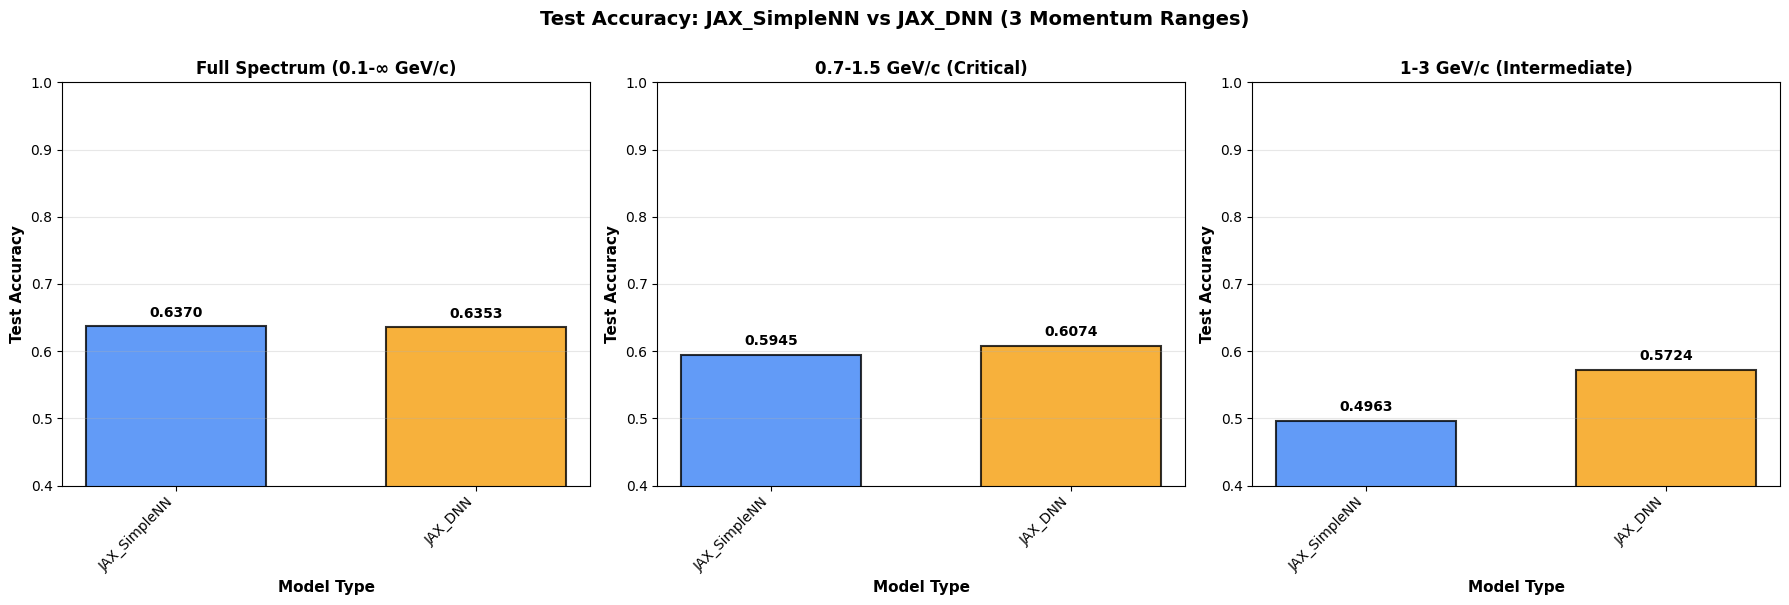

✓ Model accuracy comparison generated


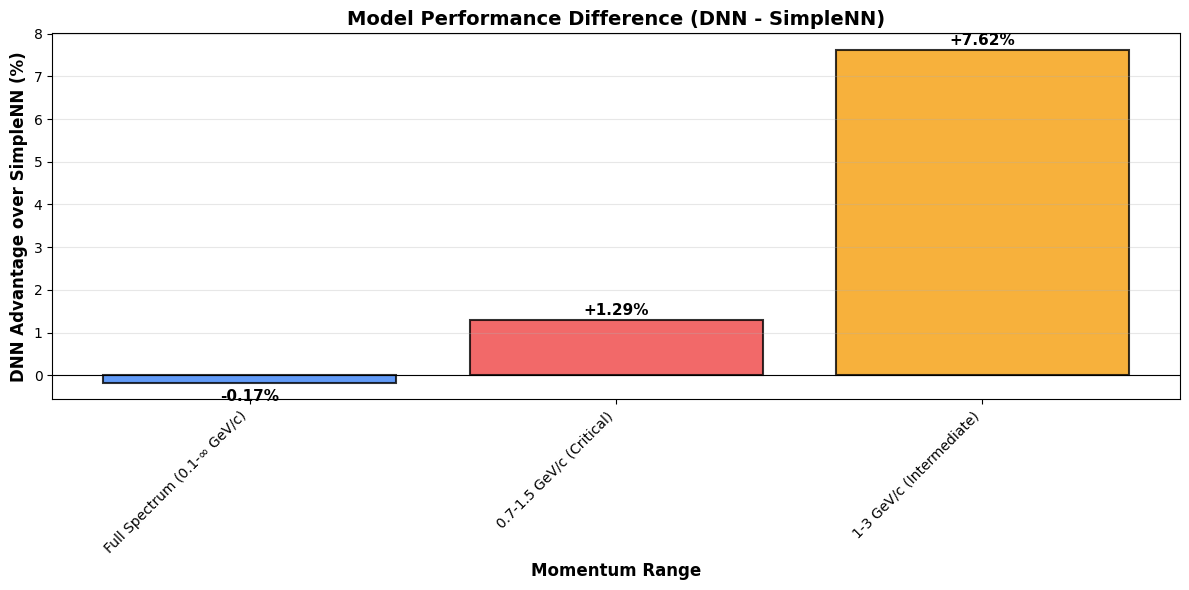

✓ Model performance difference generated


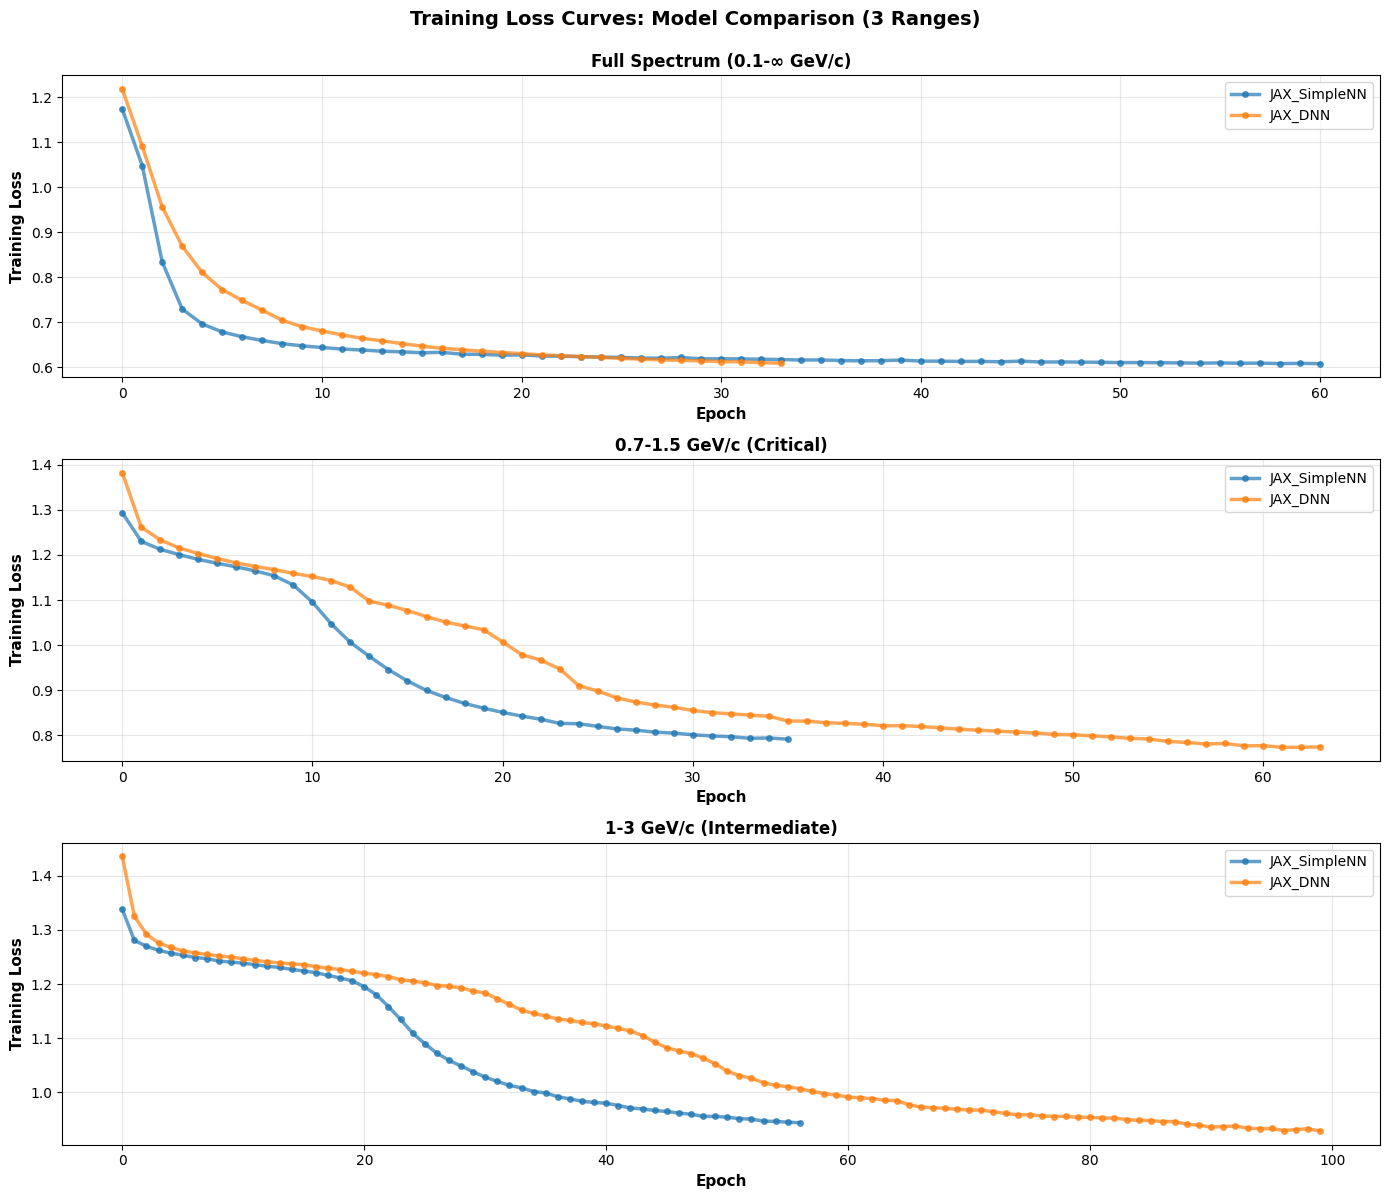

✓ Training curves comparison generated


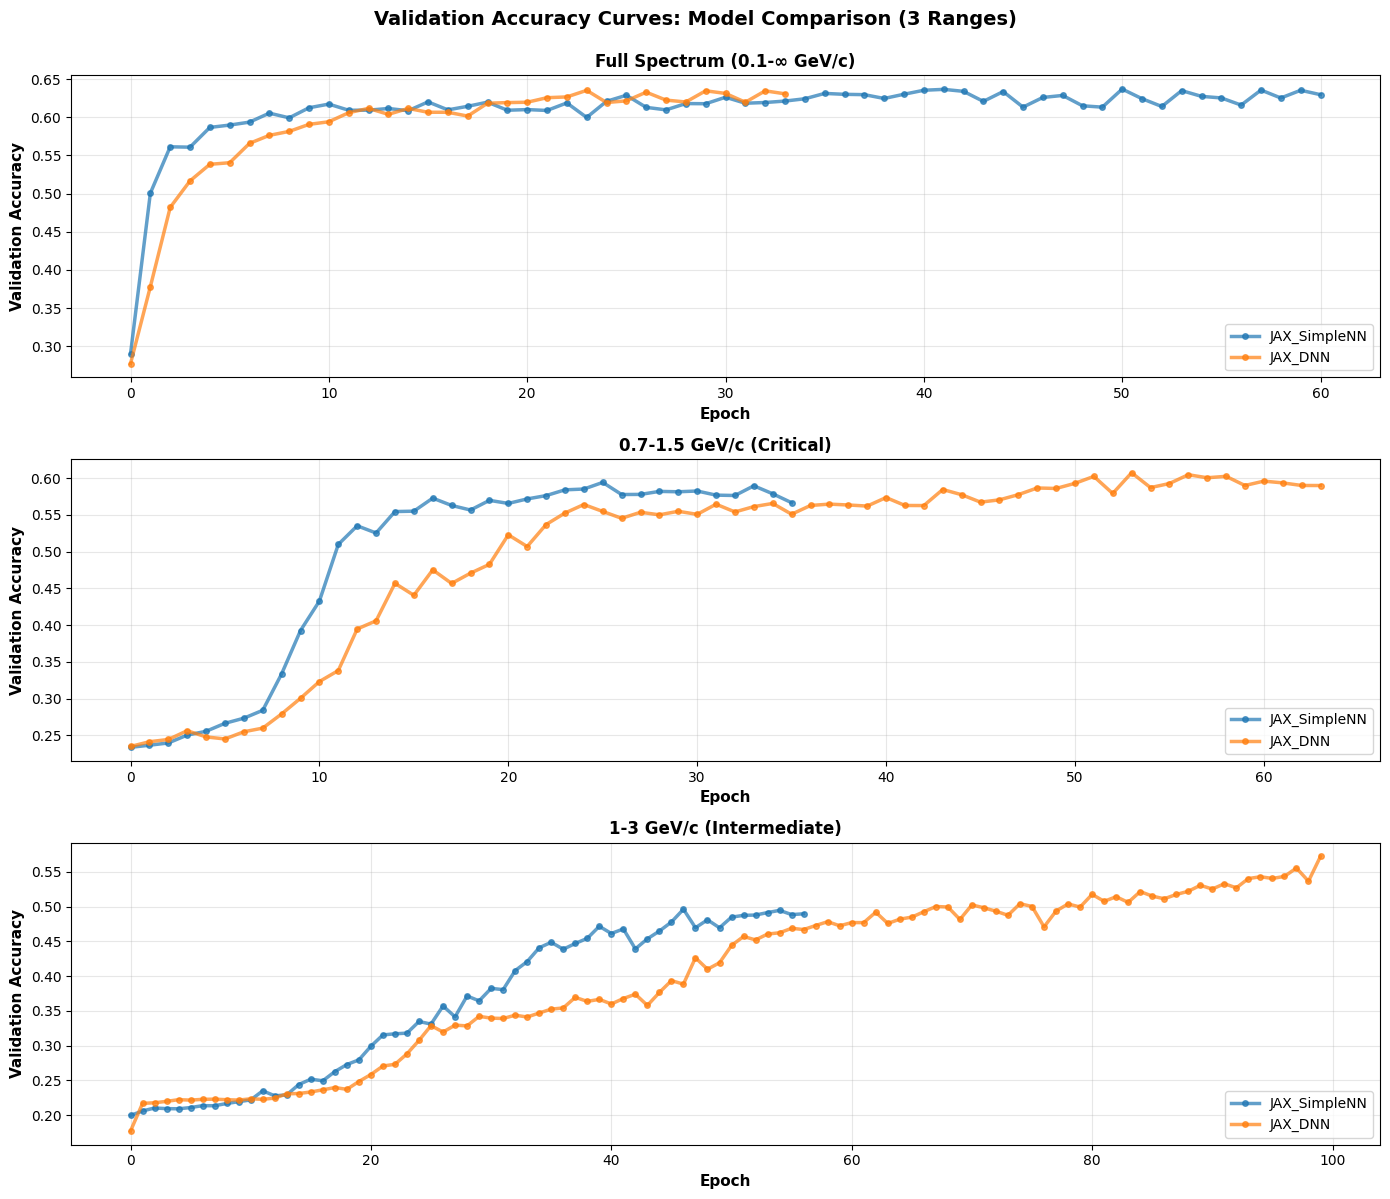

✓ Validation accuracy curves comparison generated


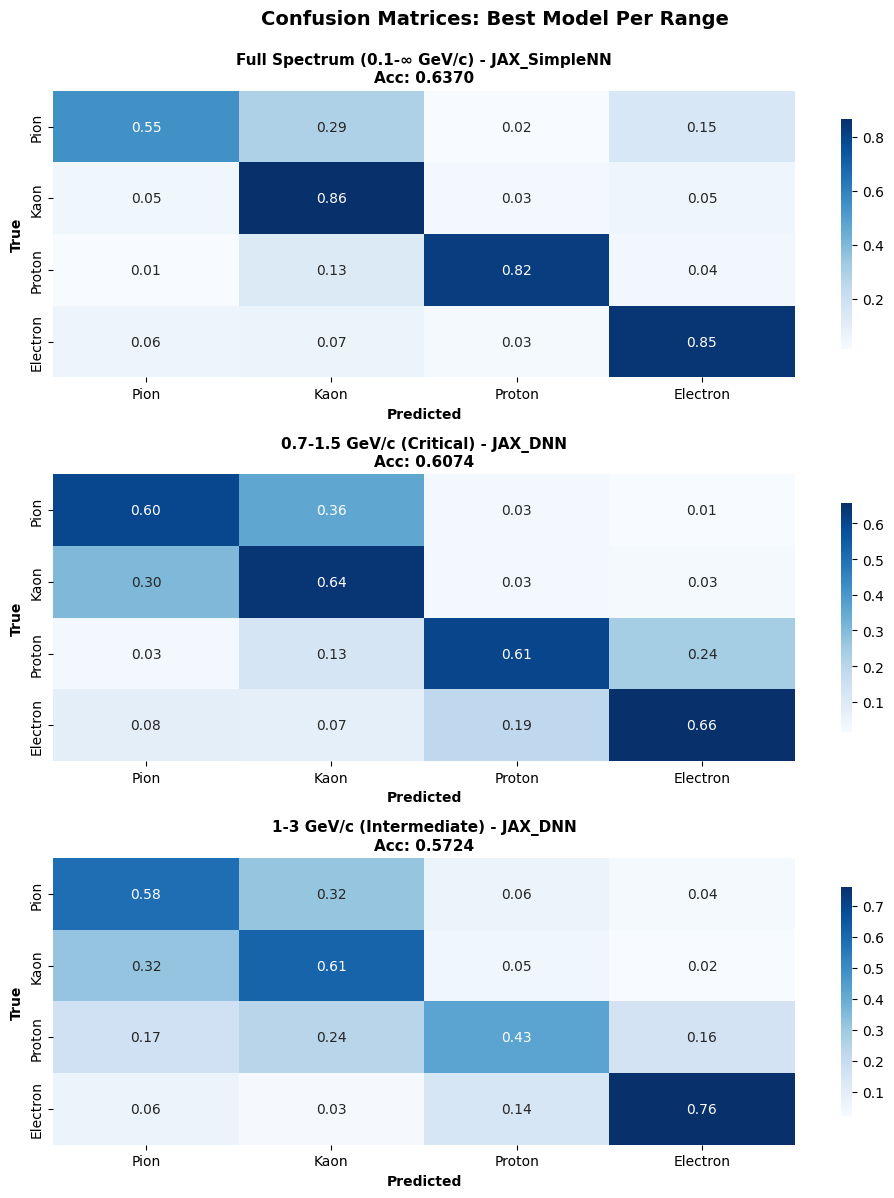

✓ Confusion matrices comparison generated

✓ SECTION 5A COMPLETE: Comparison Visualisations Generated



In [14]:
# ============================================================================
# SECTION 5A: ADVANCED COMPARISON VISUALISATIONS (NO OPTUNA, 6 MODELS)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5A: COMPARISON VISUALISATIONS")
print(f"{'#'*80}")

# ============================================================================
# COMPARISON: MODEL TYPES ACCURACY SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("GENERATING ADVANCED COMPARISON VISUALISATIONS")
print(f"{'='*80}\n")

# Build comprehensive comparison table
comparison_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            
            comparison_data.append({
                'Momentum Range': momentum_range['name'],
                'Model Type': model_type,
                'Train Acc': f"{results['train_acc']:.4f}",
                'Test Acc': f"{results['test_acc']:.4f}",
                'Best Val Acc': f"{results['best_val_acc']:.4f}"
            })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print(f"{'='*80}\n")
print(comparison_df.to_string(index=False))
print()

# ============================================================================
# COMPARISON: TEST ACCURACY BY MODEL (Bar Chart) - 3 RANGES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for plot_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    model_labels = []
    test_accs = []
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            model_labels.append(model_type)
            test_accs.append(mr_data[model_type]['test_acc'])
    
    # Set up bar positions
    x = np.arange(len(model_labels))
    width = 0.6
    
    # Plot bars
    bars = axes[plot_idx].bar(x, test_accs, width, 
                              color=['#3B82F6', '#F59E0B'], alpha=0.8, 
                              edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[plot_idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.4f}', ha='center', va='bottom', 
                          fontsize=10, fontweight='bold')
    
    # Customise plot
    axes[plot_idx].set_xlabel('Model Type', fontsize=11, fontweight='bold')
    axes[plot_idx].set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    axes[plot_idx].set_title(f'{momentum_range["name"]}', 
                            fontsize=12, fontweight='bold')
    axes[plot_idx].set_xticks(x)
    axes[plot_idx].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[plot_idx].set_ylim([0.4, 1.0])
    axes[plot_idx].grid(axis='y', alpha=0.3)

plt.suptitle('Test Accuracy: JAX_SimpleNN vs JAX_DNN (3 Momentum Ranges)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Model accuracy comparison generated")

# ============================================================================
# COMPARISON: MODEL PERFORMANCE DIFFERENCE
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

differences = []
range_labels = []
colors_list = []
color_map = {
    'full': '#3B82F6',      # Blue
    '0.7-1.5': '#EF4444',   # Red
    '1-3': '#F59E0B'        # Orange
}

for mr_key in all_results_by_model_and_range.keys():
    mr_data = all_results_by_model_and_range[mr_key]
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    if 'JAX_SimpleNN' in mr_data and 'JAX_DNN' in mr_data:
        simplenn_acc = mr_data['JAX_SimpleNN']['test_acc']
        dnn_acc = mr_data['JAX_DNN']['test_acc']
        
        # DNN advantage over SimpleNN
        difference = (dnn_acc - simplenn_acc) * 100
        differences.append(difference)
        range_labels.append(momentum_range['name'])
        colors_list.append(color_map[mr_key])

# Plot bars
bars = ax.bar(range(len(differences)), differences, color=colors_list, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height > 0 else -0.15),
            f'{diff:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=11, fontweight='bold')

# Customise plot
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Momentum Range', fontsize=12, fontweight='bold')
ax.set_ylabel('DNN Advantage over SimpleNN (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Difference (DNN - SimpleNN)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(range_labels)))
ax.set_xticklabels(range_labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Model performance difference generated")

# ============================================================================
# COMPARISON: TRAINING CURVES (Loss) - 3 RANGES
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            train_losses = np.array(results['train_losses'])
            ax.plot(train_losses, linewidth=2.5, label=model_type, marker='o', 
                   markersize=4, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3)
    plot_idx += 1

plt.suptitle('Training Loss Curves: Model Comparison (3 Ranges)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Training curves comparison generated")

# ============================================================================
# COMPARISON: VALIDATION ACCURACY CURVES - 3 RANGES
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            val_accs = np.array(results['val_accuracies'])
            ax.plot(val_accs, linewidth=2.5, label=model_type, marker='o',
                   markersize=4, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(alpha=0.3)
    plot_idx += 1

plt.suptitle('Validation Accuracy Curves: Model Comparison (3 Ranges)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Validation accuracy curves comparison generated")

# ============================================================================
# COMPARISON: CONFUSION MATRICES (Best Model Per Range)
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    # Find best model for this range
    best_acc = 0
    best_model_type = None
    best_results = None
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            if results['test_acc'] > best_acc:
                best_acc = results['test_acc']
                best_model_type = model_type
                best_results = results
    
    ax = axes[mr_idx]
    
    # Compute confusion matrix
    y_test = best_results['y_test']
    y_pred = best_results['y_pred_test']
    
    cm = confusion_matrix(y_test, np.array(y_pred), normalize='true')
    
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=PARTICLE_NAMES,
               yticklabels=PARTICLE_NAMES,
               cbar_kws={'shrink': 0.8},
               ax=ax,
               cbar=True)
    
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('True', fontsize=10, fontweight='bold')
    
    title = f'{momentum_range["name"]} - {best_model_type}'
    title += f'\nAcc: {best_acc:.4f}'
    
    ax.set_title(title, fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices: Best Model Per Range', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Confusion matrices comparison generated")

print(f"\n{'='*80}")
print("✓ SECTION 5A COMPLETE: Comparison Visualisations Generated")
print(f"{'='*80}\n")


### Section 5B: ROC/AUC Curves and Summary Statistics


################################################################################
SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS
################################################################################

✓ Generating ROC/AUC curves...


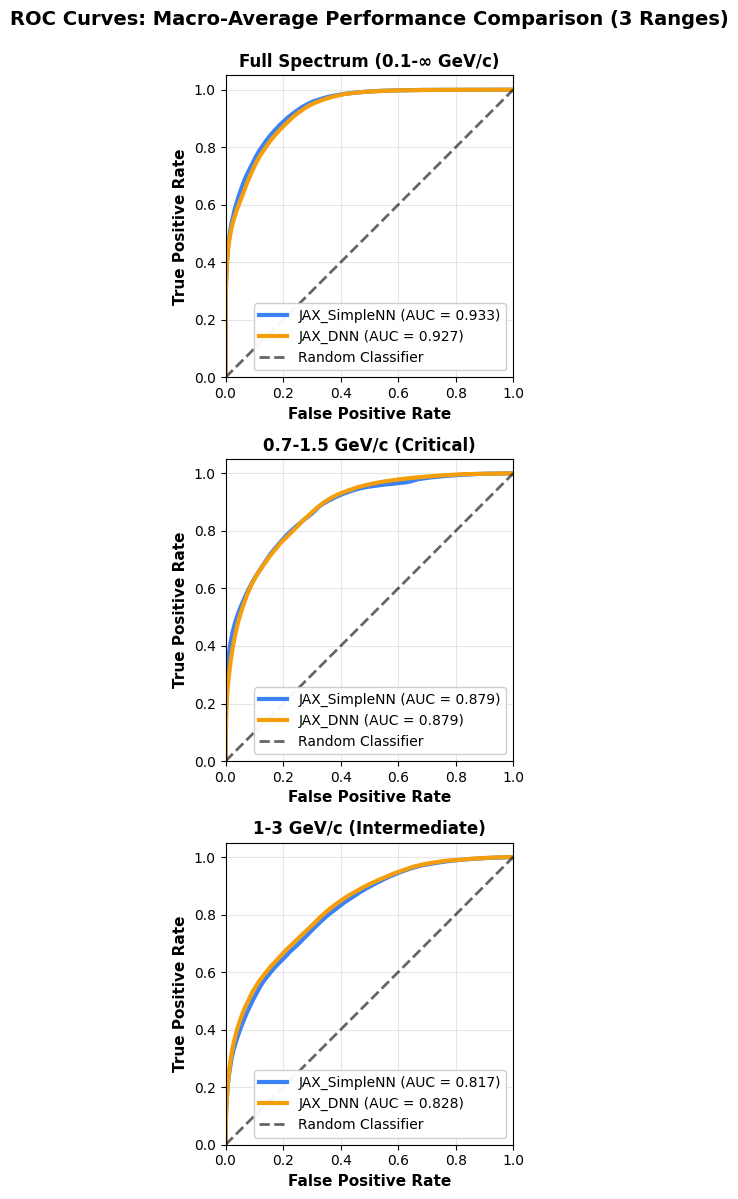

✓ ROC/AUC curves generated

AUC SCORES SUMMARY

             Momentum Range        Model   Pion   Kaon Proton Electron Macro-avg Micro-avg
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN 0.9187 0.8966 0.9771   0.9407    0.9333    0.9203
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN 0.9075 0.8942 0.9743   0.9322    0.9270    0.9232
   0.7-1.5 GeV/c (Critical) JAX_SimpleNN 0.8728 0.7402 0.9535   0.9488    0.8788    0.8855
   0.7-1.5 GeV/c (Critical)      JAX_DNN 0.8808 0.7545 0.9422   0.9377    0.8788    0.8881
   1-3 GeV/c (Intermediate) JAX_SimpleNN 0.7747 0.7237 0.8252   0.9459    0.8174    0.8124
   1-3 GeV/c (Intermediate)      JAX_DNN 0.7909 0.7368 0.8286   0.9557    0.8280    0.8418


FEATURE IMPORTANCE ANALYSIS

Computing feature importance for all models...

  Full Spectrum (0.1-∞ GeV/c):
    ✓ JAX_SimpleNN: computed
    ✓ JAX_DNN: computed
  0.7-1.5 GeV/c (Critical):
    ✓ JAX_SimpleNN: computed
    ✓ JAX_DNN: computed
  1-3 GeV/c (Intermediate):
    ✓ JAX_SimpleNN: computed
    ✓ JAX_DNN:

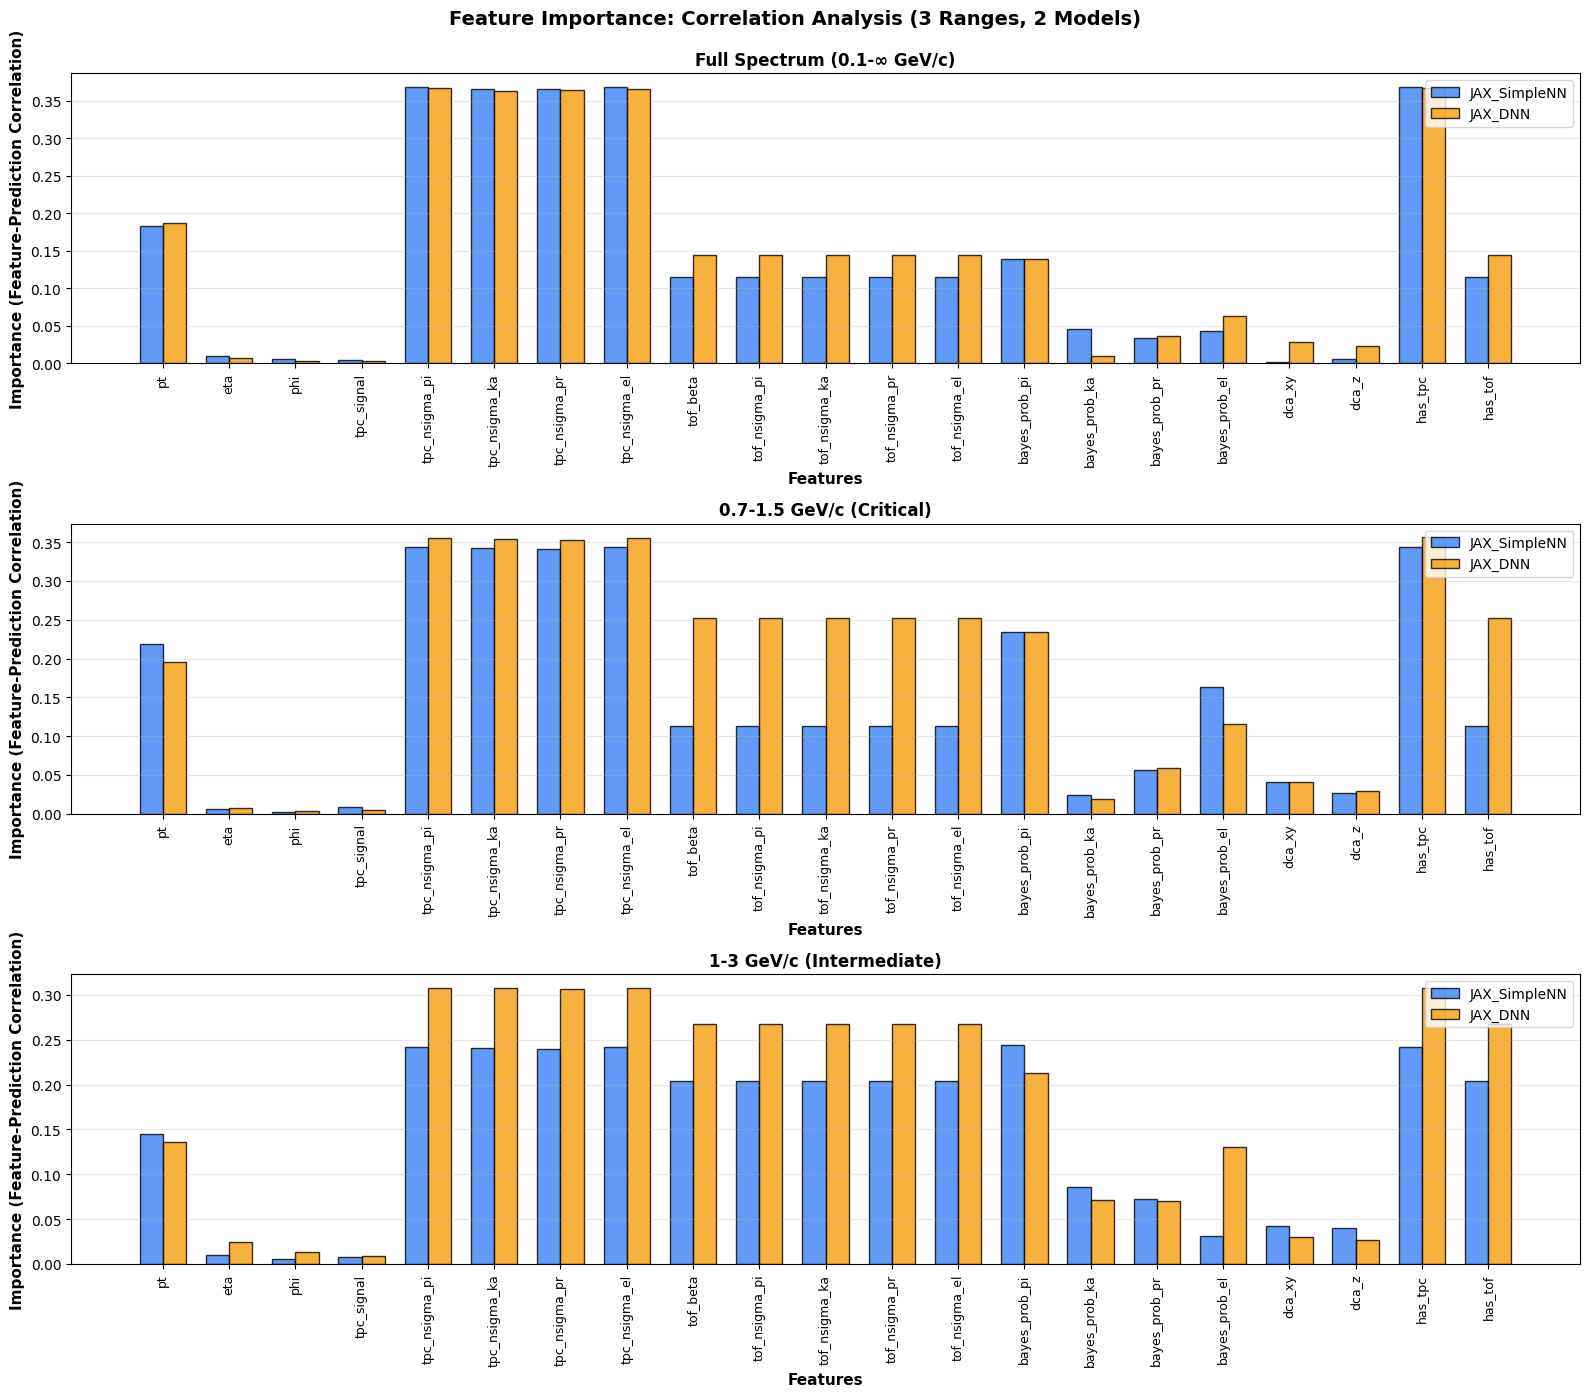

✓ Feature importance plots generated

TOP 5 IMPORTANT FEATURES BY MODEL & RANGE


Full Spectrum (0.1-∞ GeV/c):

  JAX_SimpleNN:
    1. tpc_nsigma_pi       : 0.367947
    2. has_tpc             : 0.367818
    3. tpc_nsigma_el       : 0.367636
    4. tpc_nsigma_pr       : 0.365822
    5. tpc_nsigma_ka       : 0.365473

  JAX_DNN:
    1. has_tpc             : 0.366225
    2. tpc_nsigma_pi       : 0.366191
    3. tpc_nsigma_el       : 0.365263
    4. tpc_nsigma_pr       : 0.363821
    5. tpc_nsigma_ka       : 0.363456

0.7-1.5 GeV/c (Critical):

  JAX_SimpleNN:
    1. has_tpc             : 0.343992
    2. tpc_nsigma_el       : 0.343842
    3. tpc_nsigma_pi       : 0.343216
    4. tpc_nsigma_ka       : 0.341886
    5. tpc_nsigma_pr       : 0.341493

  JAX_DNN:
    1. has_tpc             : 0.356060
    2. tpc_nsigma_pi       : 0.355380
    3. tpc_nsigma_el       : 0.355061
    4. tpc_nsigma_ka       : 0.353872
    5. tpc_nsigma_pr       : 0.352947

1-3 GeV/c (Intermediate):

  JAX_SimpleNN:


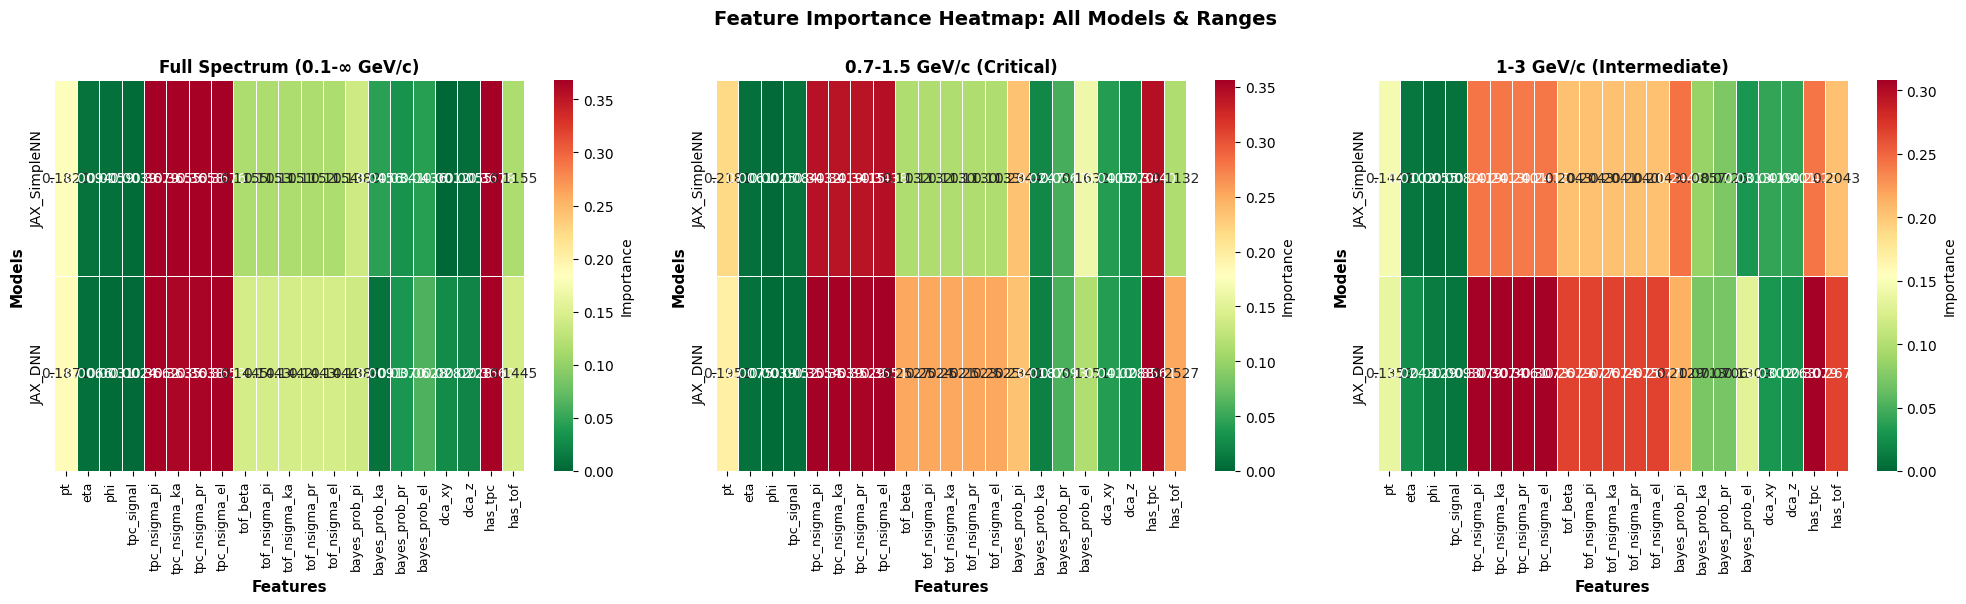

✓ Feature importance heatmap generated

SUMMARY STATISTICS BY MODEL TYPE


────────────────────────────────────────────────────────────────────────────────
MODEL: JAX_SimpleNN
────────────────────────────────────────────────────────────────────────────────

  Full Spectrum (0.1-∞ GeV/c):
    Train Acc: 0.6362
    Test Acc:  0.6370
    Best Val:  0.6370

  0.7-1.5 GeV/c (Critical):
    Train Acc: 0.5961
    Test Acc:  0.5945
    Best Val:  0.5942

  1-3 GeV/c (Intermediate):
    Train Acc: 0.4954
    Test Acc:  0.4963
    Best Val:  0.4964

────────────────────────────────────────────────────────────────────────────────
MODEL: JAX_DNN
────────────────────────────────────────────────────────────────────────────────

  Full Spectrum (0.1-∞ GeV/c):
    Train Acc: 0.6351
    Test Acc:  0.6353
    Best Val:  0.6353

  0.7-1.5 GeV/c (Critical):
    Train Acc: 0.6081
    Test Acc:  0.6074
    Best Val:  0.6074

  1-3 GeV/c (Intermediate):
    Train Acc: 0.5704
    Test Acc:  0.5724
    Best Va

In [16]:
# ============================================================================
# SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS")
print(f"{'#'*80}")

# ============================================================================
# COMPARISON: ROC CURVES (SIMPLIFIED) - 3 RANGES
# ============================================================================

print("\n✓ Generating ROC/AUC curves...")

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

macro_colors = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B'
}

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    ax = axes[plot_idx]
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            
            # Compute macro-average ROC curve and AUC
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(NUM_CLASSES):
                fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Compute macro-average
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(NUM_CLASSES):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= NUM_CLASSES
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            
            # Plot macro-average ROC curve
            ax.plot(fpr["macro"], tpr["macro"],
                   color=macro_colors[model_type], 
                   linewidth=3,
                   label=f'{model_type} (AUC = {roc_auc["macro"]:.3f})')
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6, label='Random Classifier')
    
    # Customise plot
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    
    ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    
    plot_idx += 1

plt.suptitle('ROC Curves: Macro-Average Performance Comparison (3 Ranges)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ ROC/AUC curves generated")

# ============================================================================
# AUC SCORES SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("AUC SCORES SUMMARY")
print(f"{'='*80}\n")

auc_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            
            # Compute AUC for each class
            class_aucs = []
            for i in range(NUM_CLASSES):
                fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
                class_aucs.append(auc(fpr, tpr))
            
            # Compute macro and micro AUC
            macro_auc = np.mean(class_aucs)
            micro_auc = roc_auc_score(
                np.eye(NUM_CLASSES)[y_test], 
                y_score, 
                average='micro'
            )
            
            auc_data.append({
                'Momentum Range': momentum_range['name'],
                'Model': model_type,
                'Pion': f"{class_aucs[0]:.4f}",
                'Kaon': f"{class_aucs[1]:.4f}",
                'Proton': f"{class_aucs[2]:.4f}",
                'Electron': f"{class_aucs[3]:.4f}",
                'Macro-avg': f"{macro_auc:.4f}",
                'Micro-avg': f"{micro_auc:.4f}"
            })

auc_df = pd.DataFrame(auc_data)
print(auc_df.to_string(index=False))
print()

# ============================================================================
# FEATURE IMPORTANCE ANALYSIS: CORRELATION-BASED
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*80}\n")

feature_importance_data = {}

print("Computing feature importance for all models...\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    feature_importance_data[mr_key] = {}
    
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    features = all_results_by_model_and_range[mr_key]['preprocessing']['features']
    
    print(f"  {momentum_range['name']}:")
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            
            # Use correlation-based feature importance
            y_pred = np.array(results['y_pred_test'])
            y_test_arr = np.array(results['y_test'])
            
            # Compute feature importance as correlation with correct predictions
            importances = []
            correct_predictions = (y_pred == y_test_arr).astype(float)
            
            for feature_idx in range(X_test_scaled.shape[1]):
                feature_values = X_test_scaled[:, feature_idx]
                # Correlation between feature values and prediction correctness
                corr_matrix = np.corrcoef(feature_values, correct_predictions)
                correlation = np.abs(corr_matrix[0, 1])
                # Handle NaN values
                if np.isnan(correlation):
                    correlation = 0.0
                importances.append(correlation)
            
            feature_importance_data[mr_key][model_type] = {
                'importances': np.array(importances),
                'features': features
            }
            
            print(f"    ✓ {model_type}: computed")

print(f"\n{'='*80}")

# ============================================================================
# PLOT: FEATURE IMPORTANCE COMPARISON - ALL RANGES & MODELS
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    ax = axes[plot_idx]
    
    features = list(feature_importance_data[mr_key].values())[0]['features']
    x_pos = np.arange(len(features))
    width = 0.35
    
    # Get importance for both models
    simplenn_imp = None
    dnn_imp = None
    
    if 'JAX_SimpleNN' in feature_importance_data[mr_key]:
        simplenn_imp = feature_importance_data[mr_key]['JAX_SimpleNN']['importances']
    
    if 'JAX_DNN' in feature_importance_data[mr_key]:
        dnn_imp = feature_importance_data[mr_key]['JAX_DNN']['importances']
    
    # Plot bars
    if simplenn_imp is not None:
        ax.bar(x_pos - width/2, simplenn_imp, width, 
              label='JAX_SimpleNN', color='#3B82F6', alpha=0.8, edgecolor='black')
    
    if dnn_imp is not None:
        ax.bar(x_pos + width/2, dnn_imp, width, 
              label='JAX_DNN', color='#F59E0B', alpha=0.8, edgecolor='black')
    
    # Customise plot
    ax.set_xlabel('Features', fontsize=11, fontweight='bold')
    ax.set_ylabel('Importance (Feature-Prediction Correlation)', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(features, rotation=90, fontsize=9)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plot_idx += 1

plt.suptitle('Feature Importance: Correlation Analysis (3 Ranges, 2 Models)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Feature importance plots generated")

# ============================================================================
# TOP FEATURES SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("TOP 5 IMPORTANT FEATURES BY MODEL & RANGE")
print(f"{'='*80}\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    print(f"\n{momentum_range['name']}:")
    
    for model_type in MODEL_TYPES:
        if model_type in feature_importance_data[mr_key]:
            imp_dict = feature_importance_data[mr_key][model_type]
            importances = imp_dict['importances']
            features = imp_dict['features']
            
            # Get top 5
            top_indices = np.argsort(importances)[-5:][::-1]
            
            print(f"\n  {model_type}:")
            for rank, idx in enumerate(top_indices, 1):
                print(f"    {rank}. {features[idx]:20s}: {importances[idx]:.6f}")

print(f"\n{'='*80}\n")

# ============================================================================
# FEATURE IMPORTANCE HEATMAP - COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    # Get importances for both models
    importances_list = []
    model_labels = []
    features = None
    
    for model_type in MODEL_TYPES:
        if model_type in feature_importance_data[mr_key]:
            imp = feature_importance_data[mr_key][model_type]['importances']
            importances_list.append(imp)
            model_labels.append(model_type)
            if features is None:
                features = feature_importance_data[mr_key][model_type]['features']
    
    if importances_list:
        # Create heatmap data
        heatmap_data = np.array(importances_list)
        
        sns.heatmap(heatmap_data, 
                   xticklabels=features, 
                   yticklabels=model_labels,
                   cmap='RdYlGn_r',
                   ax=axes[ax_idx],
                   cbar_kws={'label': 'Importance'},
                   annot=True,
                   fmt='.4f',
                   vmin=0,
                   linewidths=0.5)
        
        axes[ax_idx].set_title(f'{momentum_range["name"]}', 
                              fontsize=12, fontweight='bold')
        axes[ax_idx].set_xlabel('Features', fontsize=11, fontweight='bold')
        axes[ax_idx].set_ylabel('Models', fontsize=11, fontweight='bold')
        
        # Rotate labels
        axes[ax_idx].set_xticklabels(features, rotation=90, fontsize=9)

plt.suptitle('Feature Importance Heatmap: All Models & Ranges', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Feature importance heatmap generated")

# ============================================================================
# SUMMARY STATISTICS BY MODEL
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS BY MODEL TYPE")
print(f"{'='*80}\n")

for model_type in MODEL_TYPES:
    print(f"\n{'─'*80}")
    print(f"MODEL: {model_type}")
    print(f"{'─'*80}")
    
    for mr_key, mr_data in all_results_by_model_and_range.items():
        momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
        
        if model_type in mr_data:
            results = mr_data[model_type]
            
            print(f"\n  {momentum_range['name']}:")
            print(f"    Train Acc: {results['train_acc']:.4f}")
            print(f"    Test Acc:  {results['test_acc']:.4f}")
            print(f"    Best Val:  {results['best_val_acc']:.4f}")

print(f"\n{'='*80}")
print("OVERALL BEST MODELS")
print(f"{'='*80}\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    best_acc = 0
    best_model = None
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            if results['test_acc'] > best_acc:
                best_acc = results['test_acc']
                best_model = model_type
    
    print(f"{momentum_range['name']:40s}: {best_model:15s} - {best_acc:.4f}")

# ============================================================================
# DIFFICULTY ANALYSIS BY MOMENTUM RANGE
# ============================================================================

print(f"\n{'='*80}")
print("MOMENTUM RANGE DIFFICULTY ANALYSIS")
print(f"{'='*80}\n")

print("Average performance across all models:\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    all_accs = []
    all_aucs = []
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            all_accs.append(results['test_acc'])
            
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            macro_auc = roc_auc_score(np.eye(NUM_CLASSES)[y_test], y_score, average='macro')
            all_aucs.append(macro_auc)
    
    avg_acc = np.mean(all_accs)
    avg_auc = np.mean(all_aucs)
    
    print(f"{momentum_range['name']:40s}:")
    print(f"  Average Accuracy:    {avg_acc:.4f}")
    print(f"  Average Macro-AUC:   {avg_auc:.4f}")
    print(f"  Difficulty Score:    {1-avg_auc:.4f} (lower AUC = more difficult)")
    print()

print(f"\n{'='*80}")
print("✓ SECTION 5B COMPLETE: ROC/AUC, Feature Importance & Summary Statistics")
print(f"{'='*80}")
print(f"\nAll 6 JAX models trained and compared:")
print(f"  ✓ JAX_SimpleNN × 3 momentum ranges = 3 models")
print(f"  ✓ JAX_DNN × 3 momentum ranges = 3 models (with BatchNorm)")
print(f"\nVisualisations & Analysis generated:")
print(f"  ✓ ROC/AUC curves (3 plots, macro-average)")
print(f"  ✓ AUC scores summary table")
print(f"  ✓ Feature importance bar charts (3 plots)")
print(f"  ✓ Top 5 important features by model")
print(f"  ✓ Feature importance heatmap (3 plots)")
print(f"  ✓ Detailed statistics by model type")
print(f"  ✓ Best models per momentum range")
print(f"  ✓ Momentum range difficulty analysis")
print(f"\n{'='*80}\n")
